In [9]:
using LinearAlgebra
using SparseArrays
using Plots

In [13]:
function xy(
    x0::Float64, 
    y0::Float64, 
    L1::Float64, 
    L2::Float64, 
    noelms1::Int64, 
    noelms2::Int64
)::Tuple{Vector{Float64}, Vector{Float64}}
    VX = repeat(collect(LinRange(x0, x0+L1, noelms1+1)), inner=noelms2+1)
    VY = repeat(collect(LinRange(y0+L2, y0, noelms2+1)), noelms1+1)
    return VX, VY
end

function conelmtab(noelms1::Int64, noelms2::Int64)::Matrix{Int64}
    k = [i for i in 1:(noelms1*(noelms2+1)) if i % (noelms2+1) != 0]

    return [
        k (2 + noelms2 .+ k) (1 + noelms2 .+ k);
        k (1 .+ k) (2 + noelms2 .+ k)
    ]
end

function basfun(
    VX::Vector{Float64}, 
    VY::Vector{Float64}, 
    EToV::Matrix{Int64}
)::Tuple{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}}
    xjs = VX[EToV[:, [2,3,1]]]
    yjs = VY[EToV[:, [2,3,1]]]

    xks = VX[EToV[:, [3,1,2]]]
    yks = VY[EToV[:, [3,1,2]]]

    as = xjs .* yks - xks .* yjs
    bs = yjs - yks
    cs = xks - xjs

    return as, bs, cs
end

basfun (generic function with 2 methods)

# Exercise 5.1

In [24]:
function assembly(
    VX::Vector{Float64},
    VY::Vector{Float64},
    EToV::Matrix{Int64},
    lam1::Float64,
    lam2::Float64,
    qt::Vector{Float64},
    ct::Vector{Float64}
)::Tuple{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Vector{Float64}}
    N = size(EToV)[1]
    M = length(VX)

    r = spzeros(M, M)
    s = spzeros(M, M)
    b_rhs = zeros(M)

    as, bs, cs = basfun(VX, VY, EToV)
    deltas = sum(as, dims=2) ./ 2
    qs = abs.(deltas) .* sum(qt[EToV], dims=2) / 9
    shs = sum(ct[EToV], dims=2) / 3
    sh_matrix = Diagonal(fill(1/12, 3)) + fill(1/12,3,3) # specific heat matrix for computation

    for nn in 1:N
        delta = abs(deltas[nn])
        shn_matrix = sh_matrix .* delta .* shs[nn]
        q = qs[nn]
        b = bs[nn, :]
        c = cs[nn, :]

        for rr in 1:3
            i = EToV[nn,rr]
            b_rhs[i] += q

            for ss in rr:3
                j = EToV[nn,ss]
                kn = (lam1*b[rr]*b[ss] + lam2*c[rr]*c[ss]) / (4 * delta)
                r[min(i, j), max(i, j)] += kn
                s[min(i, j), max(i ,j)] += shn_matrix[rr,ss]

            end
        end
    end

    return r, s, b_rhs
end

assembly (generic function with 1 method)

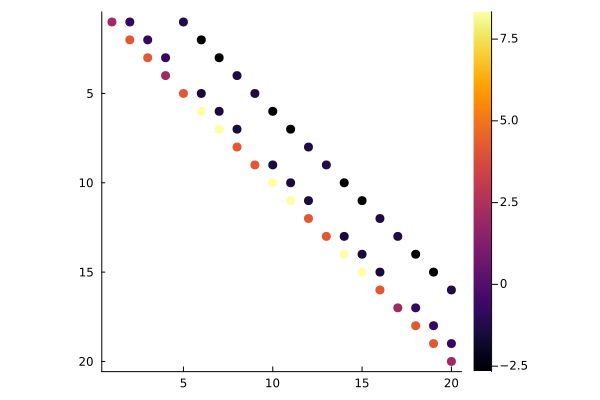

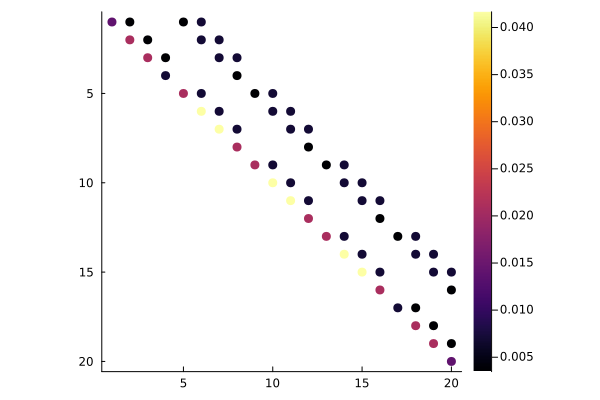

20-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [29]:
ct(x,y) = 1.0
qt(x,y) = 0.0
lam1 = lam2 = nu = 2.0
noelms1 = 4
noelms2 = 3
x0 = 0.0
y0 = 0.0
L1 = 1.0
L2 = 1.0

VX, VY = xy(x0, y0, L1, L2, noelms1, noelms2)
EToV = conelmtab(noelms1, noelms2)

r, s, b = assembly(VX, VY, EToV, lam1, lam2, qt.(VX, VY), ct.(VX,VY))
display(spy(r,markersize=5))
display(spy(s,markersize=5))
display(b)